# Secondary Experiments

In this notebook, we will be expanding on the base experiments by enhancing our RL Agent and Training Agents with various improvements. The research questions we seek to answer include:
<ul>
<li> How does the agent improve in patch selection and in accelerating training if it is trained over multiple ViT training runs, rather than just one?
<li> How does prioritized experience replay improve path selection?
<li> How might an RL agent also select images to be used for the minibatch?
<li> Would using dropout improve either the DQN or the ViT?
</ul>


In [14]:
# !pip install einops
# !pip install vit_pytorch
# !pip install torchvision


In [15]:
models_save_path        = "./model"
results_save_path_agent = "./result"
dataset_path            = "./dataset"

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
# Libraries for data handling
import numpy as np
import pandas as pd

# Libraries for image manipulation and machine learning
import torchvision
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.nn import functional
import torch.optim as optim

# Library to load in tinyimagenet
from tinyimagenet import TinyImageNet
from pathlib import Path

!pip install scikit-learn

# Libraries for model evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Libraries for tensor manipulation
from einops import rearrange
from einops.layers.torch import Rearrange

# Libraries for simulation environments (gym)
import gym

# Libraries for data visualization
import matplotlib.pyplot as plt

# Other common libraries
from collections import namedtuple
import math
import time
import os
import random

from dqn_agent import *
from train_test_agent import *
from rl_env import *
from vit import *
from viz import *


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from train_test_agent import *

<h3> Seed and Device setting

In [19]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [20]:
num_cuda_devices = torch.cuda.device_count()
print(num_cuda_devices)
if num_cuda_devices == 0:
    # raise ValueError("Not enough CUDA devices available. At least 3 are required.")
    device_our = torch.device('cpu')
    device_their = torch.device('cpu')
    device_baseline = torch.device('cpu')
    
    print("Usings CPU for all devices.")

elif num_cuda_devices == 1:
    device_our = torch.device('cuda:0')
    device_their = torch.device('cuda:0')
    device_baseline = torch.device('cuda:0')

    print(f"Using single CUDA device: {device_our}")

else:
    device_our = torch.device('cuda:0')
    device_their = torch.device('cuda:1')
    device_baseline = torch.device('cuda:2')

    print(f"Device for our model: {device_our}")
    print(f"Device for their model: {device_their}")
    print(f"Device for baseline model: {device_baseline}")


# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

0
Usings CPU for all devices.


# Dataset

<h3> Dataset Parameters

In [21]:
batch_size = 128
## Define what dataset we're using.
datasets = ["tinyimagenet", "cifar10"]
dataset_idx = 1
dataset_name = datasets[dataset_idx]
use_subset = False
subset_classes = 20
load_indices = True

if dataset_idx == 0:
    img_size = 64
    if use_subset:
        dataset_name = f"{dataset_name}_{subset_classes}_subset"
    else:
        dataset_name = f"{dataset_name}"
elif dataset_idx == 1:
    img_size = 32
    use_subset = False
    load_indices = False
        
    

# img_size = 64
# dataset_name = "CIFAR10_BIG_"
# dataset_name = "TinyImageNet"

## Train, validation and test

In [22]:
import csv
import os



transform_train = transforms.Compose([
    transforms.RandomCrop(img_size, padding=8),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std),
])

transform_validation = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std),
])

# Prepare and load TinyImageNet dataset
if (dataset_idx == 0):
    trainset_pure = TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="train",imagenet_idx=False)
    trainset =      TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="train",imagenet_idx=False, transform=transform_train)
    validationset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="val",imagenet_idx=False, transform=transform_validation)

# Prepare/download CIFAR10 dataset
if (dataset_idx == 1):
    trainset_pure = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    trainset =      torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=transform_train)
    validationset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_validation)

print("Dataset downloaded!")
# Only select 20 classes from tinyimagenet.
if use_subset:
    print("Using subset of {} classes".format(subset_classes))
     # Select 20 random classes
    selected_classes = list(range(subset_classes))
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}

    # Create a mapping from class indices to new indices
    start_time = time.time()
    # Filter the dataset to include only the selected classes
    train_indices_file = 'train_subset_indices_{subset_classes}class.csv'
    val_indices_file = 'val_subset_indices_{subset_classes}.csv'

    if os.path.exists(train_indices_file) and os.path.exists(val_indices_file) and load_indices:
        print("Loading subset indices from files...")
        with open(train_indices_file, 'r') as file:
            reader = csv.reader(file)
            train_subset_indices = list(map(int, next(reader)))

        with open(val_indices_file, 'r') as file:
            reader = csv.reader(file)
            val_subset_indices = list(map(int, next(reader)))
    else:
        print("Computing subset indices...")
        start_time = time.time()
        train_subset_indices = [i for i, (_, label) in enumerate(validationset) if label in selected_classes]
        val_subset_indices = [i for i, (_, label) in enumerate(trainset) if label in selected_classes]
        total_time = time.time() - start_time
        print(f"Time taken to compute subset indices: {total_time:.2f} seconds")
        with open('train_subset_indices_{subset_classes}class.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(train_subset_indices)

        with open('val_subset_indices_{subset_classes}.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(val_subset_indices)
    # train_subset_indices = [i for i, (_, label) in enumerate(validationset) if label in selected_classes]
    # val_subset_indices = [i for i, (_, label) in enumerate(trainset) if label in selected_classes]

    val_subset = data.Subset(validationset, train_subset_indices)
    train_subset = data.Subset(trainset, val_subset_indices)

    

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    print("trainloader created successfully.")
    dataset_size = len(val_subset)
    validation_size = int(0.95 * dataset_size)
    test_size = dataset_size - validation_size

    print("spltting dataset into validation and test sets...")
    val_subset, test_subset = data.random_split(val_subset, [validation_size, test_size])

    validation_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    classes = class_to_idx
    print(len(np.unique(val_subset.indices)))
    print(len(np.unique(train_subset.indices)))

else:
    dataset_size = len(validationset)
    validation_size = int(0.95 * dataset_size)
    test_size = dataset_size - validation_size
    validationset, testset = data.random_split(validationset, [validation_size, test_size])
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    validation_loader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    classes = trainset.classes

# classes = trainset.classes

print(classes)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataset downloaded!
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Agent

### Functions for training and validation

### Initialization

In [23]:
buffer_batch_size = 8
buffer_size = 64

gamma = 0.95

eps_start = 1
eps_end = 0.01
eps = eps_start
eps_decay = 20000

lr = 0.01

tau = 0.1
update_every = 2

get_reward_every = 10

ourPretrained = False  # Pretrained with CIFAR10 weights, that is.
pretrained = False
verbose = False     # Whether to print out training progress or not

max_reward = 10
alpha = 0.2 # Where alpha defines weight of loss reward, and 1-alpha defines weight of patch (time) reward
# loss_weight = max_reward*(alpha)  # TODO THIS ONE TOO
# time_weight = max_reward*(1-alpha) # TODO PLAY WITH THESE VALUES A LOT
loss_weight = alpha
time_weight = 1-alpha

# Input image to DQN agent's  Q-network
# for CIFAR, lowres=16, fullres=32
# For TinyImageNet, halfres = 32, fullres = 64
dqn_img_w = img_size // 2
dqn_input_channels = 3
dqn_input_size = dqn_img_w*dqn_img_w*dqn_input_channels # input to DQN (mlp type)

In [24]:
# This is the number of patches along the width/height of the square image.
# TODO refactor...img_size is defined WAY up in the notebook, right before dataset loader initialization
patch_width = 4
# patch_size = int(img_size/patch_width)
patch_size = patch_width # This is what you get when you work with someone else's code and don't want to rewrite everything.


total_patches = int((img_size/patch_width)**2)
print(total_patches)
n_patch_selected = int(total_patches*(40/64)) # From the paper


att_dim = 128

epochs = 20
save_every = 10
learning_rate = 0.001


# Definte the three transformer models.
SimpleAgentViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)

OurViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)

BaselineSimpleViT = SimpleViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)

# Sposta il modello sulla GPU (se disponibile)
SimpleAgentViTnet.to(device_their)
OurViTnet.to(device_our)
BaselineSimpleViT.to(device_baseline)
    
# definiamo l'ottimizzatore
SimpleOptimizer =   optim.Adam(SimpleAgentViTnet.parameters(), lr=learning_rate)
OurOptimizer =      optim.Adam(OurViTnet.parameters(), lr=learning_rate)
BaselineOptimizer = optim.Adam(BaselineSimpleViT.parameters(), lr=learning_rate)

64


In [25]:


#env = ViTEnv(ViTnet, total_patches, optimizer, loss_weight, time_weight, device, n_patch_selected)
theirEnv = ViTEnv(SimpleAgentViTnet, total_patches, SimpleOptimizer, loss_weight, time_weight, device_their, n_patch_selected, verbose=verbose, total_epochs=epochs)
ourEnv = OurViTEnv(OurViTnet, total_patches, OurOptimizer, loss_weight, time_weight, device_our, n_patch_selected, verbose=verbose, total_epochs=epochs)

In [26]:
ourModel = OurTrainingTestingAgent(epochs = epochs,
                             model = OurViTnet,
                             get_reward_every = get_reward_every,
                             buffer_batch_size = buffer_batch_size,
                             batch_size = batch_size,
                             env = ourEnv,
                             att_dim = att_dim,
                             n_patches = total_patches,
                             buffer_size = buffer_size,
                             gamma = gamma,
                             tau = tau,
                             update_every = update_every,
                             lr = lr,
                             eps_end = eps_end,
                             eps_start = eps_start,
                             eps_decay = eps_decay,
                             train_loader = train_loader,
                             validation_loader = validation_loader,
                             device = device_our,
                             dqn_input_size=dqn_input_size,
                             save_every=save_every,
                             verbose=verbose,
                             pretrained=ourPretrained)

theirModel = TrainingTestingAgent(epochs = epochs,
                             model = SimpleAgentViTnet,
                             get_reward_every = get_reward_every,
                             buffer_batch_size = buffer_batch_size,
                             batch_size = batch_size,
                             env = theirEnv,
                             att_dim = att_dim,
                             n_patches = total_patches,
                             buffer_size = buffer_size,
                             gamma = gamma,
                             tau = tau,
                             update_every = update_every,
                             lr = lr,
                             eps_end = eps_end,
                             eps_start = eps_start,
                             eps_decay = eps_decay,
                             train_loader = train_loader,
                             validation_loader = validation_loader,
                             save_every=save_every,
                             verbose=verbose,
                             device = device_their)

baselineModel = SimpleViTTrainingTestingAgent(epochs = epochs,
                             batch_size = batch_size, 
                             model = BaselineSimpleViT,
                             train_loader = train_loader, 
                             validation_loader = validation_loader, 
                             device = device_baseline,
                             optimizer=BaselineOptimizer, 
                            #  criterion=criterion,
                             save_every=save_every, 
                             verbose=verbose)

ConvNet created! Value of pretrained: False
ConvNet created! Value of pretrained: False


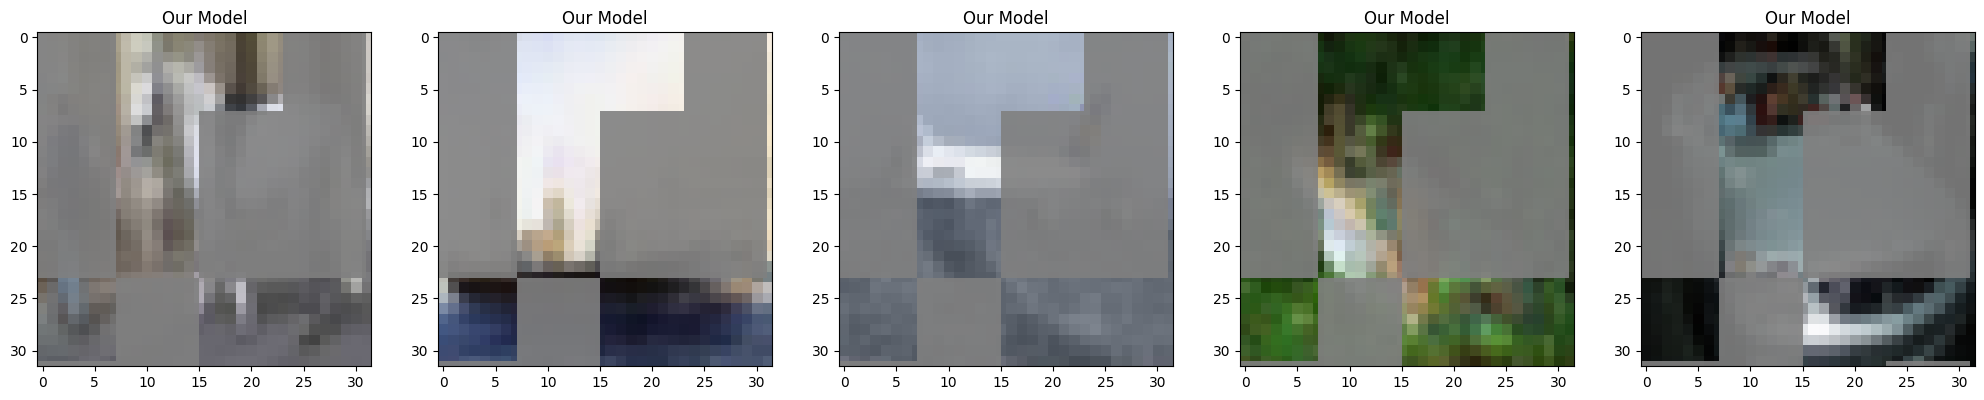

In [27]:
## Visualize the patch selection and attention scores for the untrained models.
## Use functions defined in viz.py
# Select a random set of 5 images from the dataset
num_images = 5
random_indices = np.random.choice(len(trainset_pure), num_images, replace=False)
random_images = [trainset_pure[i][0] for i in random_indices]



half_norm_transform = transforms.Compose(
    [transforms.Resize((img_size // 2, img_size // 2)), 
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std)]
    )

# # Visualize the patch selection and attention scores
# for img in random_images:
#     if dataset_idx == 0:
#         input_img = half_norm_transform(img)
#     elif dataset_idx == 1:
#         input_img = transforms.ToTensor()(img)
#         img = transforms.ToTensor()(img)
#     visualize_selected_patches(img, input_img, ourModel.agent, device_our)
#     # visualize_attention_scores(img, model.ViTnet, device)

random_images = [transforms.ToTensor()(img) for img in random_images]
visualize_selected_patches_multiple_images(random_images, random_images, ourModel.agent, device_our, titles=["Our Model" for _ in range(num_images)])


### Training

In [28]:
# BioAgentViT
def trainModel(model, models_save_path, model_name, dataset_name):
    initial = time.time()
    step_reward, selected_patch = model.train_test(models_save_path, dataset_name)
    print(f'{model_name} Total Training Time: {time.time()-initial}')

def plotTrainingInfo(model, model_name, dataset_name):
    # Collect train and validation information
    our_train_info = pd.DataFrame(model.train_info())
    our_validation_info = pd.DataFrame(model.validation_info())

    # Extract loss and accuracy information
    our_train_loss = our_train_info['train_loss']
    our_validation_loss = our_validation_info['validation_loss']
    our_validation_acc = our_validation_info['validation_acc']

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training and validation loss
    axs[0].plot(range(len(our_train_loss)), our_train_loss, label='Our Model Train Loss')
    axs[0].plot(range(len(our_validation_loss)), our_validation_loss, label='Our Model Validation Loss')
    axs[0].legend()
    axs[0].set_title('Training and Validation Loss for ' + model_name + ' on ' + dataset_name)
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    # Plot validation accuracy
    axs[1].plot(range(len(our_validation_acc)), our_validation_acc, label='Our Model Validation Accuracy')
    axs[1].legend()
    axs[1].set_title('Validation Accuracy for ' + model_name + ' on ' + dataset_name)
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')

    plt.show()

#### Question: How does the agent improve in patch selection and in accelerating training if it is trained over multiple ViT training runs, rather than just one?

In [29]:
num_iterations = 5

for i in range(num_iterations):
    print(f"Iteration {i+1}/{num_iterations}")
    trainModel(ourModel, models_save_path, "Our Model", dataset_name)
    plotTrainingInfo(ourModel, "Our Model", dataset_name)
    # Reset the ViT model after training.
    # Maintain the DQN for re-training/fine-tuning.
    OurViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)
    # Reassign the ViT model to the agent. 
    # Destroy the old model first
    del ourModel.ViTnet
    ourModel.ViTnet = OurViTnet
    
# Do the same but for theirModel
for i in range(num_iterations):
    print(f"Iteration {i+1}/{num_iterations}")
    trainModel(theirModel, models_save_path, "Their Model", dataset_name)
    plotTrainingInfo(theirModel, "Their Model", dataset_name)
    # Reset the ViT model after training.
    SimpleAgentViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)
    # Reassign the ViT model to the agent.
    # Destroy the old model first
    del theirModel.ViTnet
    theirModel.ViTnet = SimpleAgentViTnet
    
# trainModel(ourModel, models_save_path, "Our Model", dataset_name)
# trainModel(theirModel, models_save_path, "Their Model", dataset_name)
# trainModel(baselineModel, models_save_path, "Baseline Model", dataset_name)




Epoch: 1/20


KeyboardInterrupt: 

<h3> Train and Validation Information

In [17]:
import datetime
import os
import pandas as pd

# Collect train and validation information from each model
our_train_info = pd.DataFrame(ourModel.train_info())
our_validation_info = pd.DataFrame(ourModel.validation_info())

their_train_info = pd.DataFrame(theirModel.train_info())
their_validation_info = pd.DataFrame(theirModel.validation_info())

baseline_train_info = pd.DataFrame(baselineModel.train_info())
baseline_validation_info = pd.DataFrame(baselineModel.validation_info())

# Save the training and validation information to the ./results folder
results_folder = "./results"

# Ensure the results folder exists
os.makedirs(results_folder, exist_ok=True)

# Get the current timestamp
timestamp = datetime.datetime.now().strftime("%m%d_%H%M")

# Optional user-provided identifier for our model
our_model_id = "default_id"  # Replace with the actual identifier if provided

# Save our model's training and validation info
our_train_info.to_csv(os.path.join(results_folder, f"our_model_train_info_{our_model_id}_{timestamp}.csv"), index=False)
our_validation_info.to_csv(os.path.join(results_folder, f"our_model_validation_info_{our_model_id}_{timestamp}.csv"), index=False)

# Save their model's training and validation info
their_train_info.to_csv(os.path.join(results_folder, f"their_model_train_info_{timestamp}.csv"), index=False)
their_validation_info.to_csv(os.path.join(results_folder, f"their_model_validation_info_{timestamp}.csv"), index=False)

# Save baseline model's training and validation info
baseline_train_info.to_csv(os.path.join(results_folder, f"baseline_model_train_info_{timestamp}.csv"), index=False)
baseline_validation_info.to_csv(os.path.join(results_folder, f"baseline_model_validation_info_{timestamp}.csv"), index=False)

### Plot of Results

<h3> Train/Validation Loss and Train/Val Accuracy Across Epochs

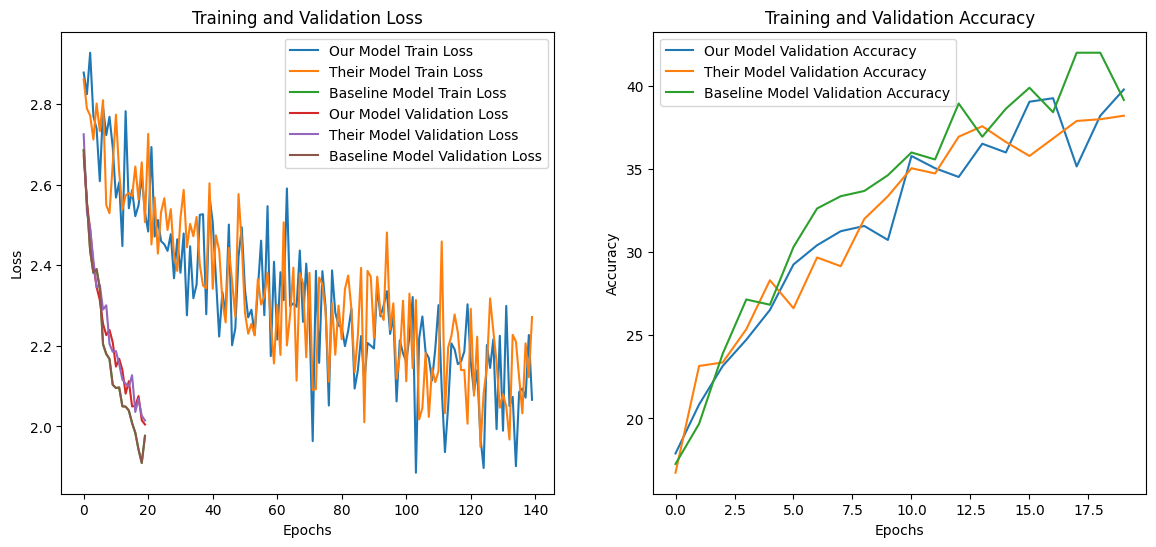

In [ ]:
# Assuming the training and validation information has been collected in the previous cells
# and stored in the variables: our_train_info, our_validation_info, their_train_info, their_validation_info, baseline_train_info, baseline_validation_info

# Extract loss and accuracy information
our_train_loss = our_train_info['train_loss']
our_validation_loss = our_validation_info['validation_loss']
# our_train_acc = our_train_info['accuracy']
our_validation_acc = our_validation_info['validation_acc']

their_train_loss = their_train_info['train_loss']
their_validation_loss = their_validation_info['validation_loss']
# their_train_acc = their_train_info['accuracy']
their_validation_acc = their_validation_info['validation_acc']

baseline_train_loss = baseline_train_info['train_loss']
baseline_validation_loss = baseline_validation_info['validation_loss']
# baseline_train_acc = baseline_train_info['accuracy']
baseline_validation_acc = baseline_validation_info['validation_acc']

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation loss
axs[0].plot(range(len(our_train_loss)), our_train_loss, label='Our Model Train Loss')
axs[0].plot(range(len(their_train_loss)), their_train_loss, label='Their Model Train Loss')
axs[0].plot(range(len(baseline_train_loss)), baseline_train_loss, label='Baseline Model Train Loss')
axs[0].plot(range(len(our_validation_loss)), our_validation_loss, label='Our Model Validation Loss')
axs[0].plot(range(len(their_validation_loss)), their_validation_loss, label='Their Model Validation Loss')
axs[0].plot(range(len(baseline_validation_loss)), baseline_validation_loss, label='Baseline Model Validation Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot training and validation accuracy
# axs[1].plot(range(len(our_train_acc)), our_train_acc, label='Our Model Train Accuracy')
axs[1].plot(range(len(our_validation_acc)), our_validation_acc, label='Our Model Validation Accuracy')
# axs[1].plot(range(len(their_train_acc)), their_train_acc, label='Their Model Train Accuracy')
axs[1].plot(range(len(their_validation_acc)), their_validation_acc, label='Their Model Validation Accuracy')
# axs[1].plot(range(len(baseline_train_acc)), baseline_train_acc, label='Baseline Model Train Accuracy')
axs[1].plot(range(len(baseline_validation_acc)), baseline_validation_acc, label='Baseline Model Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

plt.show()

## Evaluation for different Heuristics

### Train

<h3> All Patches

In [ ]:
evaluate_agent(OurViTnet, train_loader, device_our, ourEnv)
evaluate_agent(SimpleAgentViTnet, train_loader, device_their, theirEnv)
evaluate_agent(BaselineSimpleViT, train_loader, device_baseline, ourEnv)
# evaluate_agent(ViTnet, train_loader, device, env)


Average test loss: 1.9853  Accuracy: 3922/10000 (39.22%)



TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

<h3> Patches Selected By agent

In [ ]:
evaluate_agent(OurViTnet, train_loader, device_our, ourEnv, mode="agent")
evaluate_agent(SimpleAgentViTnet, train_loader, device_their, theirEnv, mode="agent")

<h3> Random Patches

In [ ]:
evaluate_agent(OurViTnet, train_loader, device_our, ourEnv, mode="random")
evaluate_agent(SimpleAgentViTnet, train_loader, device_their, theirEnv, mode="random")

### Validation

<h3> All Patches

In [ ]:
evaluate_agent(OurViTnet, validation_loader, device_our, ourEnv)
evaluate_agent(OurViTnet, test_loader, device_our, ourEnv)
evaluate_agent(SimpleAgentViTnet, validation_loader, device_their, theirEnv)
evaluate_agent(SimpleAgentViTnet, test_loader, device_their, theirEnv)
evaluate_agent(BaselineSimpleViT, validation_loader, device_baseline, ourEnv)
evaluate_agent(BaselineSimpleViT, test_loader, device_baseline, ourEnv)

<h3> Patches Selected By agent

In [ ]:
evaluate_agent(OurViTnet, validation_loader, device_our, ourEnv, mode="random")
evaluate_agent(OurViTnet, test_loader, device_our, ourEnv, mode="agent")
evaluate_agent(SimpleAgentViTnet, validation_loader, device_their, theirEnv, mode="agent")
evaluate_agent(SimpleAgentViTnet, test_loader, device_their, theirEnv, mode="agent")
evaluate_agent(BaselineSimpleViT, validation_loader, device_baseline, ourEnv, mode="agent")
evaluate_agent(BaselineSimpleViT, test_loader, device_baseline, ourEnv, mode="agent")

### Patches Selected at Random

In [ ]:
evaluate_agent(OurViTnet, validation_loader, device_our, ourEnv, mode="random")
evaluate_agent(OurViTnet, test_loader, device_our, ourEnv, mode="random")
evaluate_agent(SimpleAgentViTnet, validation_loader, device_their, theirEnv, mode="random")
evaluate_agent(SimpleAgentViTnet, test_loader, device_their, theirEnv, mode="random")
evaluate_agent(BaselineSimpleViT, validation_loader, device_baseline, ourEnv, mode="random")
evaluate_agent(BaselineSimpleViT, test_loader, device_baseline, ourEnv, mode="random")

## Visualization

In [34]:
import torch 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def get_patch_coordinates(patch_index, patch_size, num_patches_per_row):
    row = patch_index // num_patches_per_row
    col = patch_index % num_patches_per_row
    return row * patch_size , col * patch_size

def visualize_selected_patches(image, input_img, model_agent, device):
    # model_agent.eval()
    with torch.no_grad():
        patches = model_agent.select_action(input_img.to(device))
        patches = [1 if patch > patches.mean() else 0 for patch in patches]
    
    patch_size = model_agent.patch_size
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
   
    # ax.imshow(image.cpu().numpy())
    num_patches_per_row = int(image.size(1) // patch_size)
    for i, patch in enumerate(patches):
        if patch == 0:
            y, x = get_patch_coordinates(i, patch_size, num_patches_per_row)
            rect = plt.Rectangle((x-1, y-1), patch_size, patch_size, edgecolor='none', facecolor='gray', alpha=0.9)
            # rect = plt.Rectangle((x, y), patch_size, patch_size, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    
    plt.show()

def get_image_with_selected_patches(image, input, model_agent, device):
    with torch.no_grad():
        patches = model_agent.select_action(input.to(device))
        patches = [1 if patch > patches.mean() else 0 for patch in patches]
    
    patch_size = model_agent.patch_size
    num_patches_per_row = int(image.size(1) // patch_size)
    
    image_np = image.permute(1, 2, 0).cpu().numpy()
    for i, patch in enumerate(patches):
        if patch == 0:
            y, x = get_patch_coordinates(i, patch_size, num_patches_per_row)
            # Convert all numbers into integers
            y = int(y)
            x = int(x)
            patch_size = int(patch_size)
            image_np[y:y+patch_size, x:x+patch_size] = np.array([0.5, 0.5, 0.5])  # Gray color
    
    return image_np

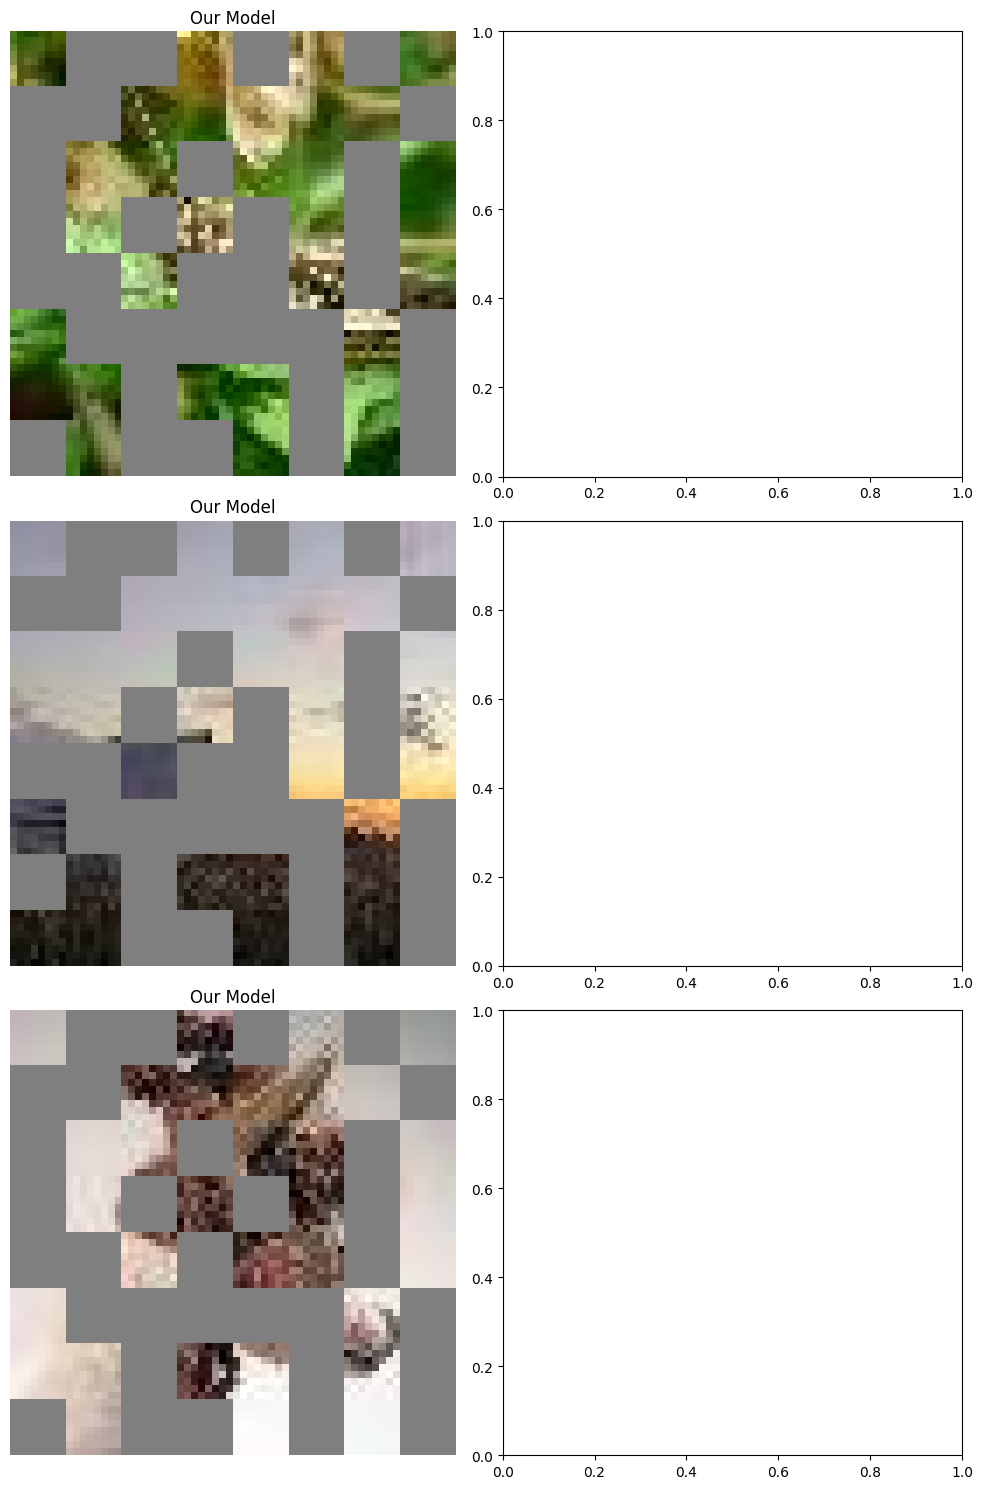

In [ ]:
## Visualize the patch selection and attention scores for the untrained models.
## Use functions defined in viz.py
# Select a random set of 5 images from the dataset
num_images = 3
random_indices = np.random.choice(len(trainset_pure), num_images, replace=False)
random_images = [trainset_pure[i][0] for i in random_indices]



half_norm_transform = transforms.Compose(
    [transforms.Resize((img_size // 2, img_size // 2)), 
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std)]
    )

fig, axs = plt.subplots(num_images, 2, figsize=(10, 15))

for i, img in enumerate(random_images):
    input_img = half_norm_transform(img)
    
    our_patches_img = get_image_with_selected_patches(img, input_img, ourModel.agent, device_our)
    their_patches_img = get_image_with_selected_patches(img, img, theirModel.agent, device_their)
    
    axs[i, 0].imshow(our_patches_img)
    axs[i, 0].set_title("Our Model")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(their_patches_img)
    axs[i, 1].set_title("Their Model")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# # Visualize the patch selection and attention scores
# for img in random_images:
#     input_img = half_norm_transform(img)
#     visualize_selected_patches(img, input_img, ourModel.agent, device_our)
#     visualize_selected_patches(img, input_img, theirModel.agent, device_their)
#     # visualize_attention_scores(img, model.ViTnet, device)